# Results for GDF+PCA+LSTM for 30 runs

Here we present results for the best LSTMs choosen based on best MCC (matthews) score on validation set. 
The features for LSTMs are GDFs reduced by PCA (number of components is chosen based on sum of explained variance ratio > 0.99).

Because LSTMs are not deterministic, the scores may vary, so we calculated scores 30 times for each model. Next we took mean obtained scores, so we can compare with scores obtained for Logistic Regression on Queue Imbalance feature (QUE+LOG).


In [1]:
%load_ext autoreload

%autoreload 2
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, roc_curve

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM


from keras.models import Sequential, model_from_json
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence


import warnings
import numpy as np
from collections import OrderedDict

import os

from lob_data_utils import lob, db_result, gdf_pca, model
from lob_data_utils.svm_calculation import lob_svm


sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
data_dir = 'res_gdf_pca_lstm_iter'
data_dir_que_log = '../queue_imbalance/res_que_log'
if_should_savefig = False

In [3]:
df_log = pd.DataFrame()
for f in os.listdir(data_dir_que_log):
    if 'csv' not in f:
        continue
    d = pd.read_csv(os.path.join(data_dir_que_log, f))
    df_log = df_log.append(d)

## Data 

Columns with suffix `lstm` are scores obtained using GDF+PCA+LSTM.

Columns with suffix `log` are scores obtained using QUE+LOG.

Columns with *prefix* `diff` are differences of scores between LSTMs - LOGs.

`r`, `s` - parameters for GDF (s - sigma, r - scale).

In [4]:
df_res = pd.DataFrame()
for f in os.listdir(data_dir):
    if 'csv' not in f:
        continue
    l = pd.read_csv(os.path.join(data_dir, f))
    df_res = df_res.append(l)  

columns = ['matthews', 'test_matthews', 'stock', 'unit']
df_best = df_res.sort_values(by='matthews', ascending=False).groupby(['stock']).mean()
df_best = pd.merge(df_best, df_log, on='stock', suffixes=['_lstm', '_log'])
df_best = df_best.drop(columns=[c for c in df_best.columns if 'Unnamed' in c])
df_best.index = df_best['stock'].astype(int)

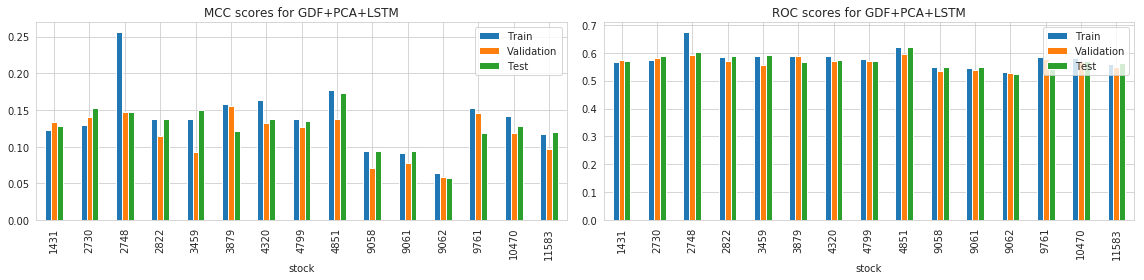

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

df_best[['train_matthews_lstm', 'matthews_lstm', 'test_matthews_lstm']].plot(kind='bar', ax=ax1)
ax1.legend(['Train', 'Validation', 'Test'])

ax1.set_title('MCC scores for GDF+PCA+LSTM')

df_best[['train_roc_auc_lstm', 'roc_auc_lstm', 'test_roc_auc_lstm']].plot(kind='bar', ax=ax2)
ax2.legend(['Train', 'Validation', 'Test'])

ax2.set_title('ROC scores for GDF+PCA+LSTM')
plt.tight_layout()
if if_should_savefig:
    plt.savefig('gdf_pca_lstm_mcc_roc_bar.png')

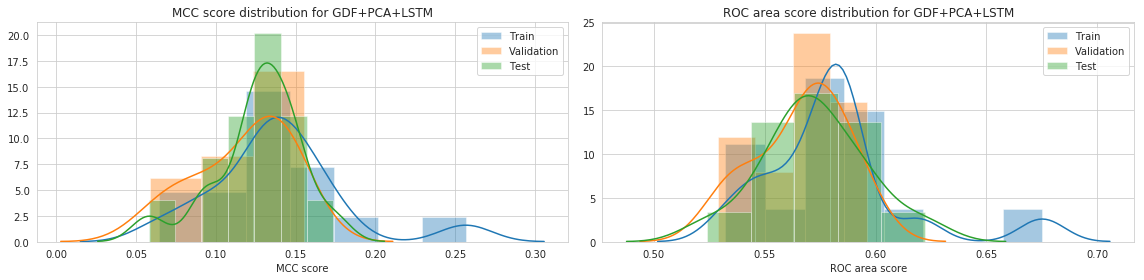

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
sns.distplot(df_best['train_matthews_lstm'], label='Train', ax=ax1)
sns.distplot(df_best['matthews_lstm'], label='Validation', ax=ax1)
sns.distplot(df_best['test_matthews_lstm'], label='Test', ax=ax1)
ax1.legend(['Train', 'Validation', 'Test'])
ax1.set_title('MCC score distribution for GDF+PCA+LSTM')
ax1.set_xlabel('MCC score')

sns.distplot(df_best['train_roc_auc_lstm'], label='Train', ax=ax2)
sns.distplot(df_best['roc_auc_lstm'], label='Validation', ax=ax2)
sns.distplot(df_best['test_roc_auc_lstm'], label='Test', ax=ax2)
ax2.legend(['Train', 'Validation', 'Test'])
ax2.set_title('ROC area score distribution for GDF+PCA+LSTM')
ax2.set_xlabel('ROC area score')

plt.tight_layout()
if if_should_savefig:
    plt.savefig('gdf_pca_lstm_score_dist.png')

In [7]:
df_best[['train_matthews_lstm', 'matthews_lstm', 'test_matthews_lstm', 
        'train_roc_auc_lstm', 'roc_auc_lstm', 'test_roc_auc_lstm']].describe()

,train_matthews_lstm,matthews_lstm,test_matthews_lstm,train_roc_auc_lstm,roc_auc_lstm,test_roc_auc_lstm
count,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000
mean,0.138903,0.116773,0.126443,0.581096,0.566333,0.572503
std,0.044075,0.030106,0.028129,0.033552,0.020351,0.024094
min,0.064279,0.058467,0.058114,0.532260,0.529052,0.524187
25%,0.119951,0.095406,0.119145,0.564808,0.552845,0.560794
50%,0.137974,0.127198,0.128872,0.581057,0.571098,0.570503
75%,0.155850,0.138593,0.142611,0.587110,0.578656,0.587449
max,0.256568,0.155287,0.173571,0.675172,0.596208,0.622194


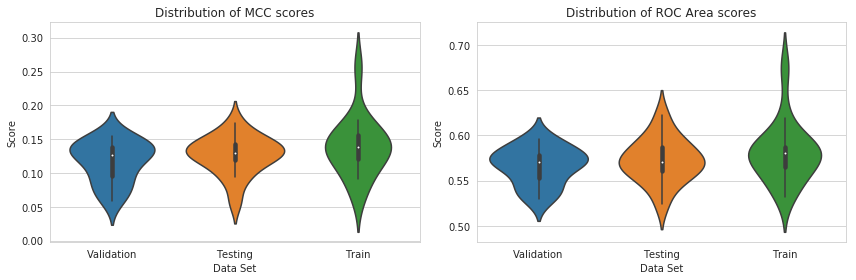

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

columns = ['stock', 'matthews_lstm', 'roc_auc_lstm', 
           'test_matthews_lstm', 'test_roc_auc_lstm', 'train_matthews_lstm', 'train_roc_auc_lstm']

df = df_best[columns].copy()
df.rename(columns={
    'matthews_lstm': 'Validation', 'test_matthews_lstm': 'Testing', 'train_matthews_lstm': 'Train'}, inplace=True)
df = df.melt(['stock', 'roc_auc_lstm', 'test_roc_auc_lstm', 'train_roc_auc_lstm'])
sns.violinplot(x="variable", y="value", data=df, ax=ax1)
ax1.set_title('Distribution of MCC scores')

ax1.set_xlabel('Data Set')
ax1.set_ylabel('Score')

df = df_best[columns].copy()
df.rename(columns={'roc_auc_lstm': 'Validation', 'test_roc_auc_lstm': 'Testing', 'train_roc_auc_lstm': 'Train'}, inplace=True)
df = df.melt(['stock', 'matthews_lstm', 'test_matthews_lstm', 'train_matthews_lstm'])

ax2.set_title('Distribution of ROC Area scores')

sns.violinplot(x="variable", y="value", data=df, ax=ax2)
ax2.set_xlabel('Data Set')
ax2.set_ylabel('Score')

plt.tight_layout()
if if_should_savefig:
    plt.savefig('violin_distribution_scores_gdf_pca_lstm.png')

In [9]:
df_best.columns

Index(['stock', 'batch_size', 'epochs', 'f1_lstm', 'kappa_lstm',
       'matthews_lstm', 'n_steps', 'pca_components', 'precision_lstm', 'r',
       'recall_lstm', 'roc_auc_lstm', 's', 'test_f1_lstm', 'test_kappa_lstm',
       'test_matthews_lstm', 'test_precision_lstm', 'test_recall_lstm',
       'test_roc_auc_lstm', 'train_f1_lstm', 'train_kappa_lstm',
       'train_matthews_lstm', 'train_precision_lstm', 'train_recall_lstm',
       'train_roc_auc_lstm', 'train_val_f1_lstm', 'train_val_kappa_lstm',
       'train_val_matthews_lstm', 'train_val_precision_lstm',
       'train_val_recall_lstm', 'train_val_roc_auc_lstm', 'f1_log', 'features',
       'kappa_log', 'kernel', 'matthews_log', 'precision_log', 'recall_log',
       'roc_auc_log', 'test_f1_log', 'test_kappa_log', 'test_matthews_log',
       'test_precision_log', 'test_recall_log', 'test_roc_auc_log',
       'train_f1_log', 'train_kappa_log', 'train_matthews_log',
       'train_precision_log', 'train_recall_log', 'train_roc_auc_log

Text(0.5,1,'Number of timesteps for LSTM')

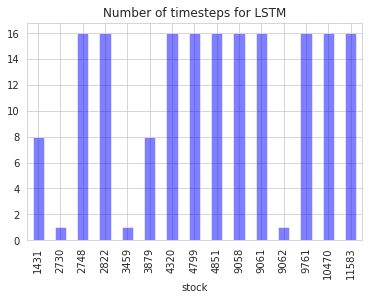

In [10]:
df_best['n_steps'].plot(kind='bar', color=['b'], alpha=0.5)
plt.title('Number of timesteps for LSTM')

## Comparision with QUE+LOG

In [11]:
df_best['diff_test_matthews'] = df_best['test_matthews_lstm'] - df_best['test_matthews_log']
df_best['diff_train_matthews'] = df_best['train_matthews_lstm'] - df_best['train_matthews_log']
df_best['diff_matthews'] = df_best['matthews_lstm'] - df_best['matthews_log']
df_best['diff_test_roc_auc'] = df_best['test_roc_auc_lstm'] - df_best['test_roc_auc_log']
df_best['diff_train_roc_auc'] = df_best['train_roc_auc_lstm'] - df_best['train_roc_auc_log']
df_best['diff_roc_auc'] = df_best['roc_auc_lstm'] - df_best['roc_auc_log']

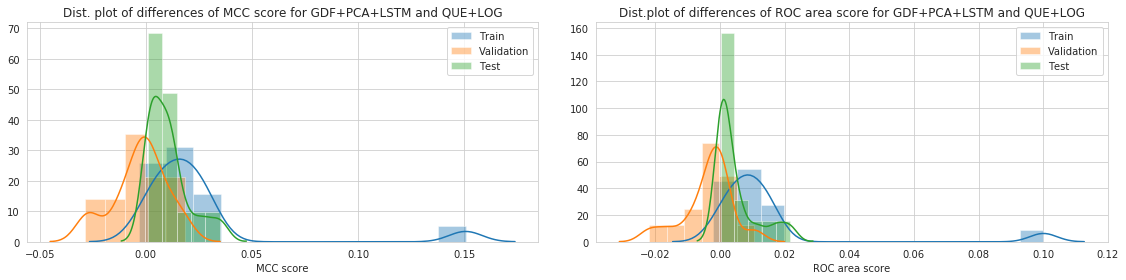

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
sns.distplot(df_best['diff_train_matthews'], label='Train', ax=ax1)
sns.distplot(df_best['diff_matthews'], label='Validation', ax=ax1)
sns.distplot(df_best['diff_test_matthews'], label='Test', ax=ax1)
ax1.set_title('Dist. plot of differences of MCC score for GDF+PCA+LSTM and QUE+LOG')
ax1.set_xlabel('MCC score')
ax1.legend()

sns.distplot(df_best['diff_train_roc_auc'], label='Train', ax=ax2)
sns.distplot(df_best['diff_roc_auc'], label='Validation', ax=ax2)
sns.distplot(df_best['diff_test_roc_auc'], label='Test', ax=ax2)
ax2.set_title('Dist.plot of differences of ROC area score for GDF+PCA+LSTM and QUE+LOG')
ax2.set_xlabel('ROC area score')
ax2.legend()
plt.tight_layout()
if if_should_savefig:
    plt.savefig('gdf_pca_lstm_and_que_log_score_diff.png')

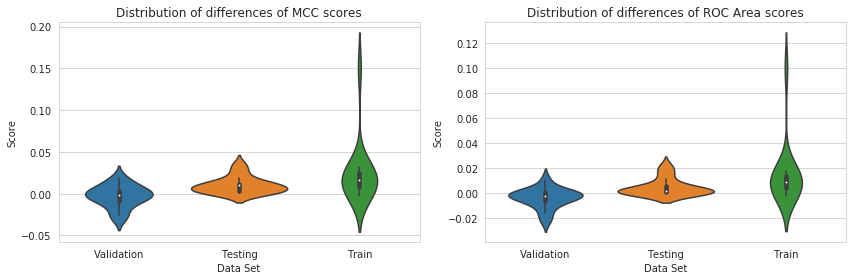

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

columns = ['stock', 'diff_matthews', 'diff_roc_auc', 
           'diff_test_matthews', 'diff_test_roc_auc', 'diff_train_matthews', 'diff_train_roc_auc']

df = df_best[columns].copy()
df.rename(columns={
    'diff_matthews': 'Validation', 'diff_test_matthews': 'Testing', 'diff_train_matthews': 'Train'}, inplace=True)
df = df.melt(['stock', 'diff_roc_auc', 'diff_test_roc_auc', 'diff_train_roc_auc'])
sns.violinplot(x="variable", y="value", data=df, ax=ax1)
ax1.set_title('Distribution of differences of MCC scores')

ax1.set_xlabel('Data Set')
ax1.set_ylabel('Score')

df = df_best[columns].copy()
df.rename(
    columns={'diff_roc_auc': 'Validation', 'diff_test_roc_auc': 'Testing', 'diff_train_roc_auc': 'Train'}, 
    inplace=True)
df = df.melt(['stock', 'diff_matthews', 'diff_test_matthews', 'diff_train_matthews'])

ax2.set_title('Distribution of differences of ROC Area scores')

sns.violinplot(x="variable", y="value", data=df, ax=ax2)
ax2.set_xlabel('Data Set')
ax2.set_ylabel('Score')

plt.tight_layout()
if if_should_savefig:
    plt.savefig('gdf_pca_lstm_and_que_log_violin_score_diff.png')

The table below shows the values for the differences, which distributions are on a plot above.

In [14]:
df_best[['diff_train_matthews', 'diff_matthews', 'diff_test_matthews', 
        'diff_train_roc_auc', 'diff_roc_auc', 'diff_test_roc_auc']].describe()

,diff_train_matthews,diff_matthews,diff_test_matthews,diff_train_roc_auc,diff_roc_auc,diff_test_roc_auc
count,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000
mean,0.024096,-0.002836,0.010465,0.014332,-0.003734,0.004788
std,0.036433,0.012935,0.009871,0.024355,0.007776,0.006699
min,-0.003234,-0.028572,0.000882,-0.002048,-0.021871,0.000179
25%,0.007514,-0.008629,0.002995,0.004297,-0.005904,0.000516
50%,0.016589,-0.001519,0.010382,0.009039,-0.002082,0.001517
75%,0.024515,0.003439,0.012081,0.013523,0.000898,0.005816
max,0.150730,0.018543,0.034950,0.100087,0.010591,0.021495


In [15]:
print(df_best[['diff_train_matthews', 'diff_matthews', 'diff_test_matthews', 
        'diff_train_roc_auc', 'diff_roc_auc', 'diff_test_roc_auc']].describe().to_latex())

\begin{tabular}{lrrrrrr}
\toprule
{} &  diff\_train\_matthews &  diff\_matthews &  diff\_test\_matthews &  diff\_train\_roc\_auc &  diff\_roc\_auc &  diff\_test\_roc\_auc \\
\midrule
count &            15.000000 &      15.000000 &           15.000000 &           15.000000 &     15.000000 &          15.000000 \\
mean  &             0.024096 &      -0.002836 &            0.010465 &            0.014332 &     -0.003734 &           0.004788 \\
std   &             0.036433 &       0.012935 &            0.009871 &            0.024355 &      0.007776 &           0.006699 \\
min   &            -0.003234 &      -0.028572 &            0.000882 &           -0.002048 &     -0.021871 &           0.000179 \\
25\%   &             0.007514 &      -0.008629 &            0.002995 &            0.004297 &     -0.005904 &           0.000516 \\
50\%   &             0.016589 &      -0.001519 &            0.010382 &            0.009039 &     -0.002082 &           0.001517 \\
75\%   &             0.024515 &    

In [16]:
df_best[['diff_test_matthews', 'stock']].sort_values(by='diff_test_matthews')

,diff_test_matthews,stock
stock,,
10470,0.000882,10470.0
3879,0.000924,3879.0
2730,0.002194,2730.0
9058,0.002958,9058.0
9061,0.003031,9061.0
4320,0.004646,4320.0
1431,0.005503,1431.0
9062,0.010382,9062.0
4799,0.010640,4799.0


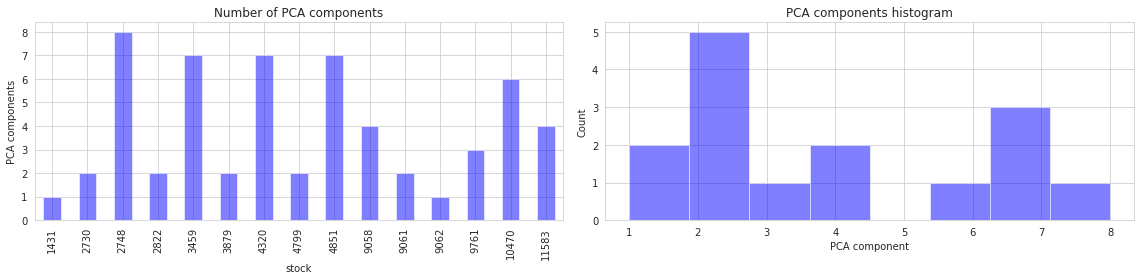

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
df_best['pca_components'].plot(kind='bar', color=['b'], alpha=0.5, ax=ax1)
ax1.set_title('Number of PCA components')
ax1.set_ylabel('PCA components')

# sns.distplot(df_best['pca_components'], ax=ax2, bins=10, kde=False)
df_best['pca_components'].hist(color='b', alpha=0.5, bins=8)
ax2.set_title('PCA components histogram')
ax2.set_ylabel('Count')
ax2.set_xlabel('PCA component')


plt.tight_layout()
if if_should_savefig:
    plt.savefig('gdf_pca_lstm_pca_components.png')

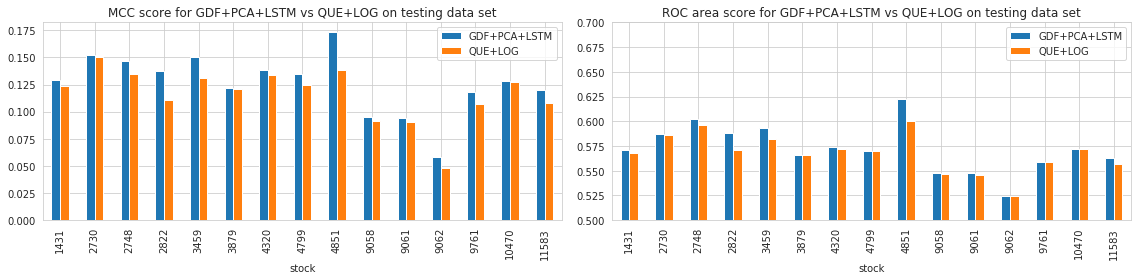

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
df_best[['test_matthews_lstm', 'test_matthews_log']].plot(kind='bar', ax=ax1)
ax1.legend(['GDF+PCA+LSTM', 'QUE+LOG'])
ax1.set_title('MCC score for GDF+PCA+LSTM vs QUE+LOG on testing data set')

df_best[['test_roc_auc_lstm', 'test_roc_auc_log']].plot(kind='bar', ax=ax2)
ax2.legend(['GDF+PCA+LSTM', 'QUE+LOG'])
ax2.set_ylim(0.5, 0.7)
ax2.set_title('ROC area score for GDF+PCA+LSTM vs QUE+LOG on testing data set')
plt.tight_layout()
if if_should_savefig:
    plt.savefig('gdf_pca_lstm_que_log_mcc_roc_scores_bar.png')

In [19]:
print('stocks having worse roc area score for LSTM vs LOG on test set')
print(df_best[df_best['test_roc_auc_lstm'] < df_best['test_roc_auc_log']]['stock'].values)
df_best[df_best['test_roc_auc_lstm'] < df_best['test_roc_auc_log']][[
    'roc_auc_lstm', 'roc_auc_log', 'test_roc_auc_lstm', 'test_roc_auc_log', 'r', 's']]

stocks having worse roc area score for LSTM vs LOG on test set
[]


,roc_auc_lstm,roc_auc_log,test_roc_auc_lstm,test_roc_auc_log,r,s
stock,,,,,,


In [20]:
print('stocks having worse MCC score for LSTM vs LOG on test set')
df_best[df_best['test_matthews_lstm'] < df_best['test_matthews_log']][[
    'matthews_lstm', 'matthews_log', 'test_matthews_lstm', 'test_matthews_log', 'r', 's']]

stocks having worse MCC score for LSTM vs LOG on test set


,matthews_lstm,matthews_log,test_matthews_lstm,test_matthews_log,r,s
stock,,,,,,


In [21]:
df_best[['train_matthews_lstm', 'train_matthews_log',
    'matthews_lstm', 'matthews_log', 'test_matthews_lstm', 'test_matthews_log', 'r', 's']]

,train_matthews_lstm,train_matthews_log,matthews_lstm,matthews_log,test_matthews_lstm,test_matthews_log,r,s
stock,,,,,,,,
1431,0.122418,0.117325,0.133613,0.134712,0.128872,0.123369,0.01,0.50
2730,0.129193,0.132427,0.140029,0.136898,0.152257,0.150063,0.01,0.10
2748,0.256568,0.105838,0.147461,0.134618,0.147088,0.134365,0.10,0.10
2822,0.137303,0.120714,0.114391,0.111058,0.137223,0.110434,0.01,0.10
3459,0.137974,0.129942,0.093433,0.122005,0.150064,0.131207,0.25,0.25
3879,0.158481,0.136130,0.155287,0.136745,0.121639,0.120715,0.01,0.10
4320,0.163376,0.142331,0.132586,0.129040,0.138134,0.133488,0.10,0.10
4799,0.138369,0.111690,0.127198,0.130257,0.134745,0.124104,0.10,0.50
4851,0.177789,0.146106,0.137156,0.148009,0.173571,0.138621,0.10,0.10


## Conclusions

GDF+PCA+LSTM is better from QUE+LOG.